In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1011. NC Well Metals/P1011.2. Analyses/P1011.2.4. Contamination Mapping/Output')
cur_date = "011325"

library(readxl)
library(tidyverse)
library(reshape2)
library(tigris)
library(cowplot)
# library(rcartocolor)
# library(RColorBrewer)
# library(MetBrewer)
# library(tidytext)

# reading in files
as_census_tracts_df = data.frame(read_excel("Input/As_Census_Tracts_010925.xlsx"))
mn_census_tracts_df = data.frame(read_excel("Input/Mn_Census_Tracts_010925.xlsx"))

as_census_tracts_df$Concentration = as.numeric(as_census_tracts_df$Concentration)
mn_census_tracts_df$Concentration = as.numeric(mn_census_tracts_df$Concentration)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [2]:
head(as_census_tracts_df)
head(mn_census_tracts_df)

,GEOID,Concentration
,<dbl>,<dbl>
1,37179020902,14.168383
2,37179020901,13.287818
3,37179020100,18.720882
4,37179020800,16.450622
5,37179020401,1.731546
6,37179020202,27.408738


,GEOID,Concentration
,<dbl>,<dbl>
1,37179020902,147.44876
2,37179020901,202.77838
3,37179020100,171.13772
4,37179020800,620.25841
5,37179020401,75.00000
6,37179020202,28.25828


Mapping arsenic and manganese concentrations across Union County, NC. 

Answering this question first: How many census tracts had concentrations above the MCL or HAL?

In [12]:
as_census_tracts_df %>%
    filter(Concentration >= 10) %>%
    count()

mn_census_tracts_df %>%
    filter(Concentration >= 300) %>%
    count()

n
<int>
14


n
<int>
5


In [3]:
# download shapefile from the tigris (census package)
union_county_census_tracts = tracts(state = 37, county = 179, year = 2018) 

head(union_county_census_tracts)

  |======================================================================| 100%


ERROR while rich displaying an object: Error in loadNamespace(x): there is no package called ‘geojsonio’

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_geojson.sf(obj)
8. repr_geojson(geo

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<MULTIPOLYGON [°]>
337,37,179,020901,37179020901,209.01,Census Tract 209.01,G5020,S,203506500,1753575,+34.8637965,-080.4247764,MULTIPOLYGON (((-80.54601 3...
338,37,179,020401,37179020401,204.01,Census Tract 204.01,G5020,S,28215452,359353,+35.0237736,-080.5546358,MULTIPOLYGON (((-80.60175 3...
339,37,179,020902,37179020902,209.02,Census Tract 209.02,G5020,S,137943408,2382720,+34.8477552,-080.6116346,MULTIPOLYGON (((-80.72832 3...
498,37,179,020800,37179020800,208,Census Tract 208,G5020,S,137993164,1498324,+34.9688372,-080.3330504,MULTIPOLYGON (((-80.42014 3...
499,37,179,020100,37179020100,201,Census Tract 201,G5020,S,222051078,1634224,+35.0964380,-080.3591790,MULTIPOLYGON (((-80.49615 3...
860,37,179,021010,37179021010,210.10,Census Tract 210.10,G5020,S,32929955,847103,+35.0217267,-080.7354087,MULTIPOLYGON (((-80.77367 3...


In [4]:
# changing some of the data types before joining files
as_census_tracts_df$GEOID = as.character(as_census_tracts_df$GEOID)
mn_census_tracts_df$GEOID = as.character(mn_census_tracts_df$GEOID)

as_df = full_join(as_census_tracts_df, union_county_census_tracts) %>%
    # creating a dichotomized concentration
    mutate(MCL = ifelse(Concentration >= 10, "Above", "Below"))

mn_df = inner_join(mn_census_tracts_df, union_county_census_tracts) %>%
    # creating a dichotomized concentration
    mutate(HAL = ifelse(Concentration >= 300, "Above", "Below"))

head(as_df)

Joining with `by = join_by(GEOID)`
Joining with `by = join_by(GEOID)`


,GEOID,Concentration,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,MCL
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<MULTIPOLYGON [°]>,<chr>
1,37179020902,14.168383,37,179,020902,209.02,Census Tract 209.02,G5020,S,137943408,2382720,+34.8477552,-080.6116346,MULTIPOLYGON (((-80.72832 3...,Above
2,37179020901,13.287818,37,179,020901,209.01,Census Tract 209.01,G5020,S,203506500,1753575,+34.8637965,-080.4247764,MULTIPOLYGON (((-80.54601 3...,Above
3,37179020100,18.720882,37,179,020100,201,Census Tract 201,G5020,S,222051078,1634224,+35.0964380,-080.3591790,MULTIPOLYGON (((-80.49615 3...,Above
4,37179020800,16.450622,37,179,020800,208,Census Tract 208,G5020,S,137993164,1498324,+34.9688372,-080.3330504,MULTIPOLYGON (((-80.42014 3...,Above
5,37179020401,1.731546,37,179,020401,204.01,Census Tract 204.01,G5020,S,28215452,359353,+35.0237736,-080.5546358,MULTIPOLYGON (((-80.60175 3...,Below
6,37179020202,27.408738,37,179,020202,202.02,Census Tract 202.02,G5020,S,79833282,523621,+35.0775080,-080.5344921,MULTIPOLYGON (((-80.59366 3...,Above


## As continuous concentrations

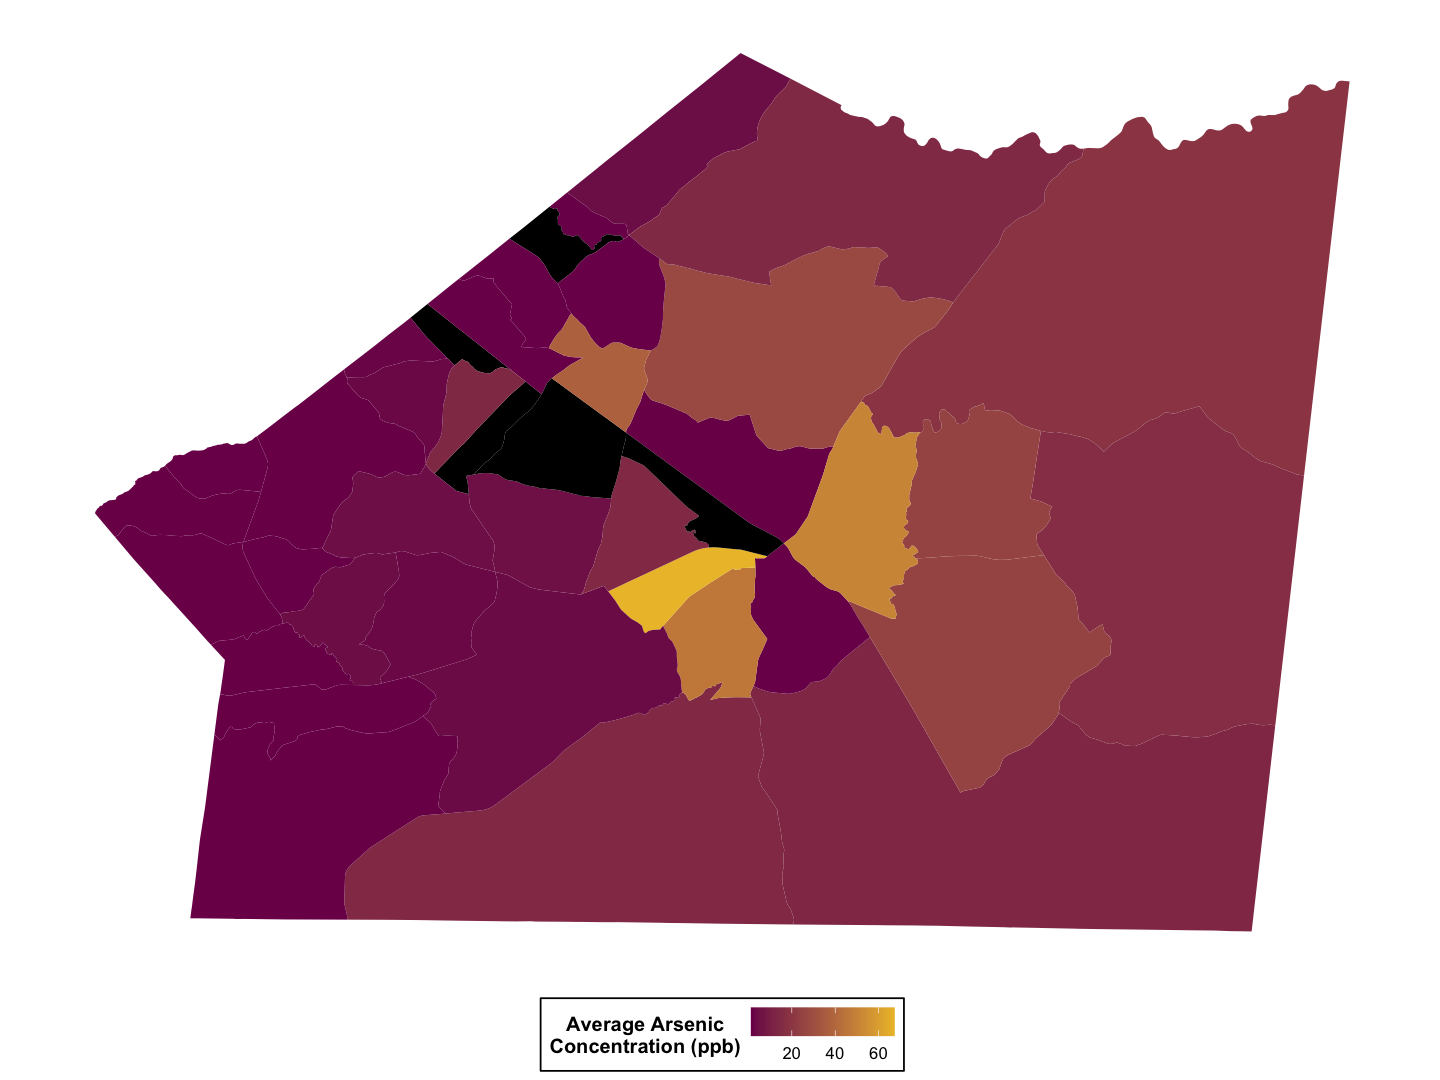

In [5]:
options(repr.plot.width = 12, repr.plot.height = 9) #changing size

Figure1a = ggplot() +
  geom_sf(data = as_df, aes(fill = Concentration, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.direction = "horizontal",
      legend.position = 'bottom',
      #legend.position = c(0.5,0), # move legend to bottom middle
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradient(low = "#7c1158",
      high = "#edbf33",
      na.value = "black",
      name = "   Average Arsenic\nConcentration (ppb)")

Figure1a

## As dichotomous concentrations

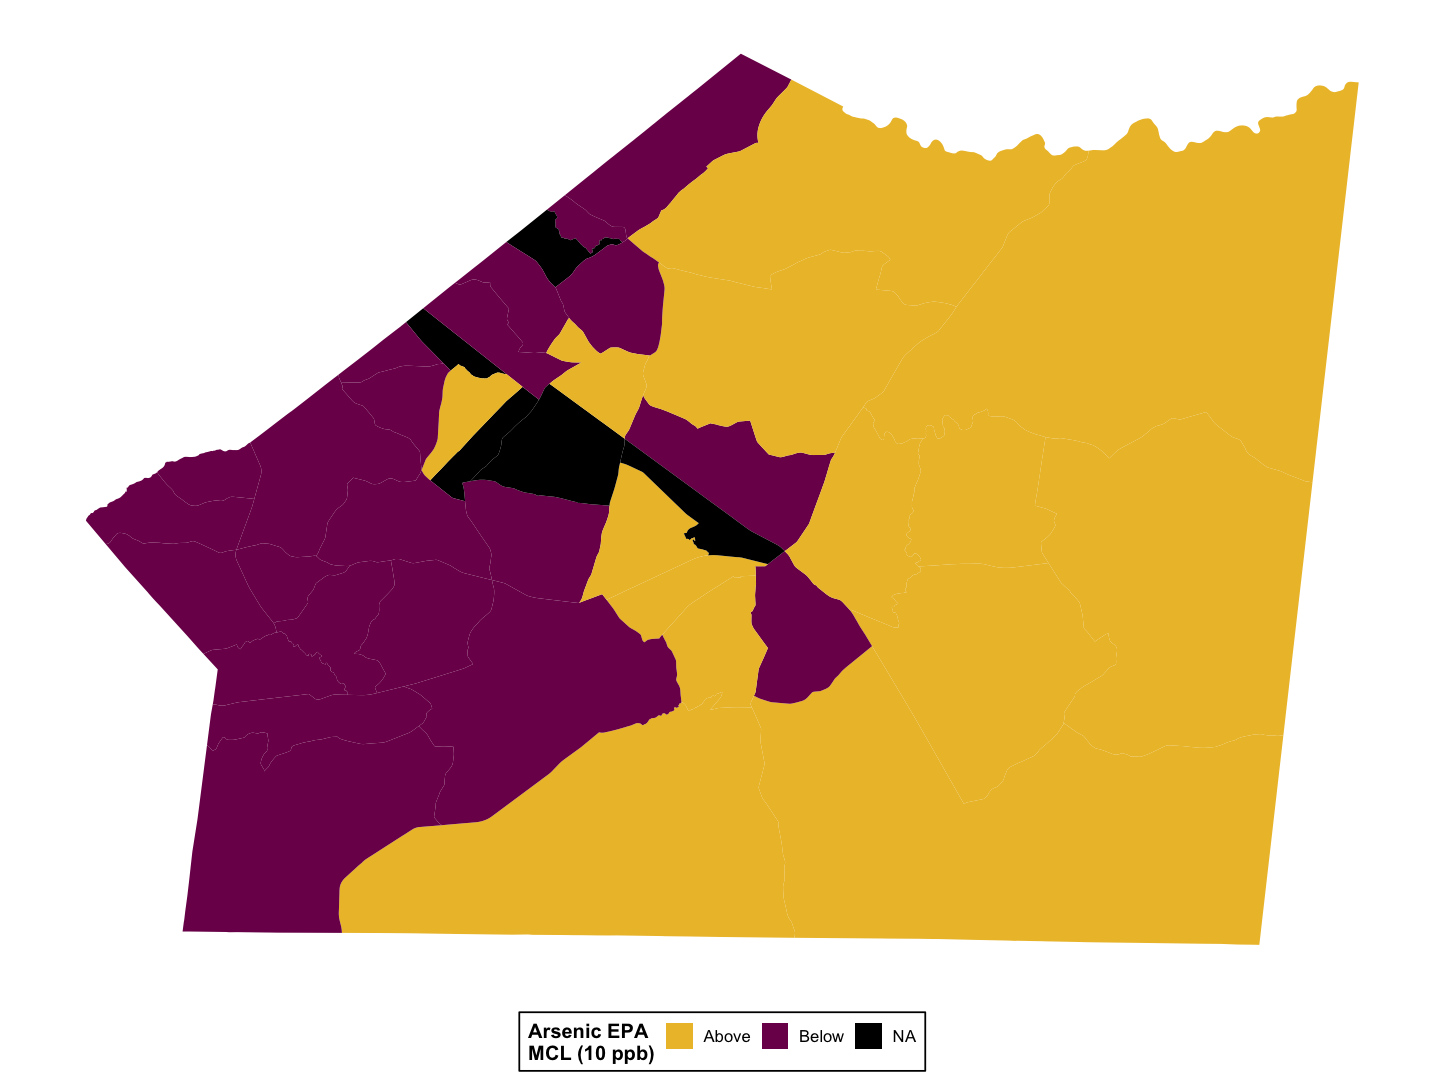

In [6]:
Figure1b = ggplot() +
  geom_sf(data = as_df, aes(fill = MCL, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      #legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.position = 'bottom',
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_manual(values = c("#edbf33", "#7c1158"), 
                    na.value = "black", # making geo ids w/ NA values black
                    name = "Arsenic EPA\nMCL (10 ppb)") 

Figure1b

## Mn continous concentrations

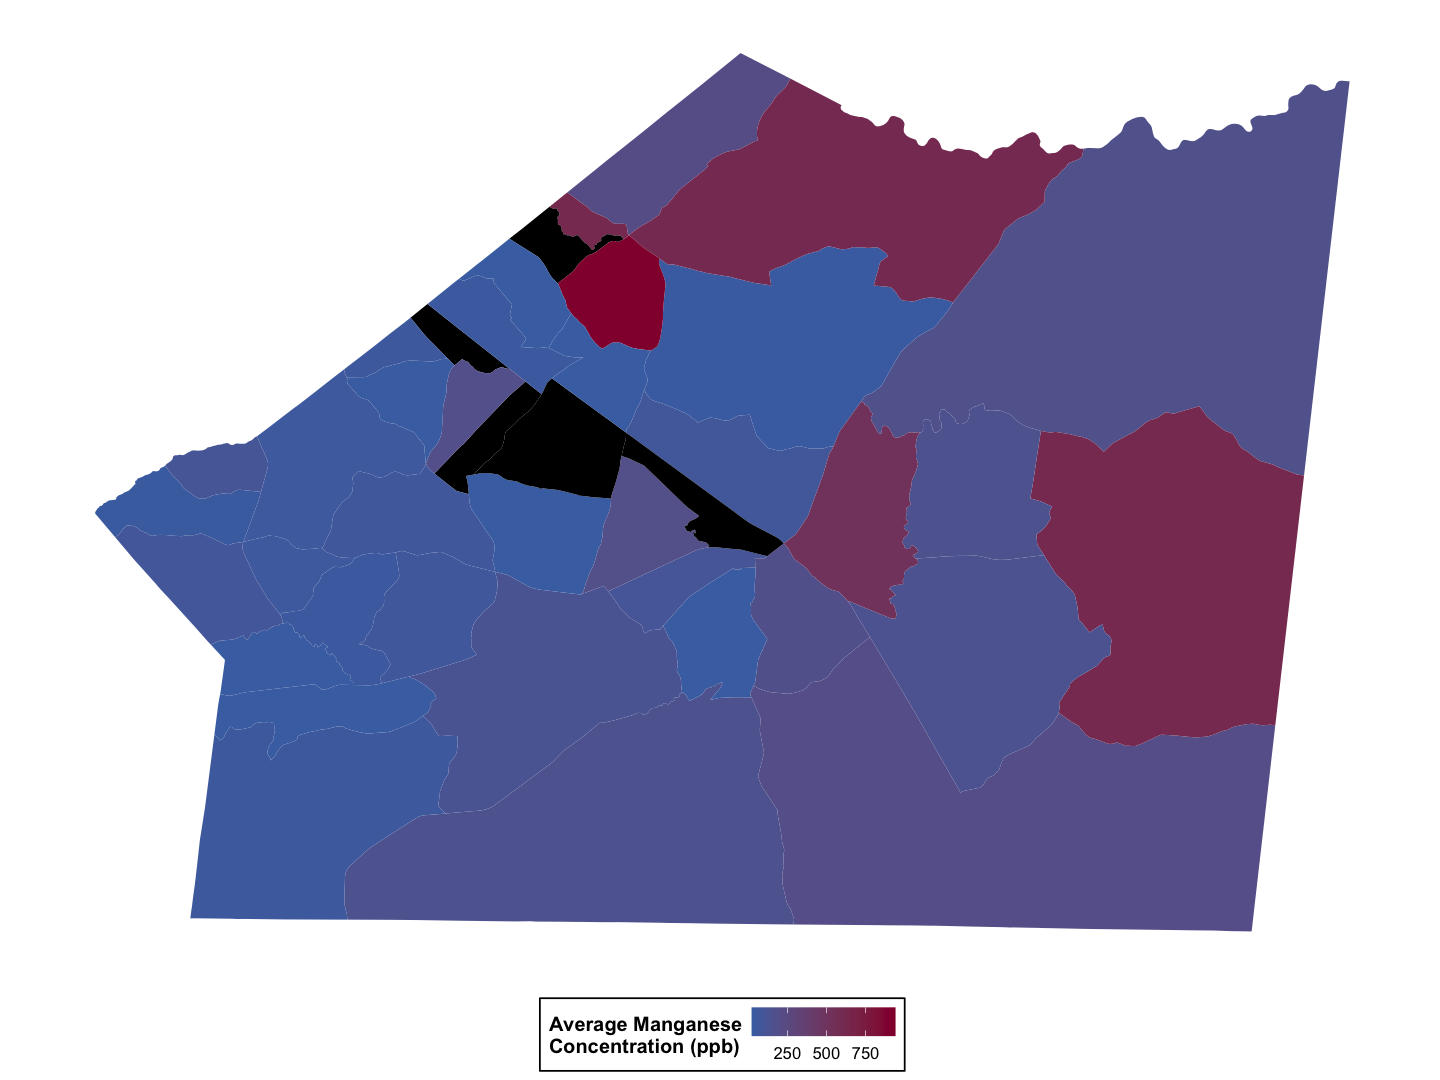

In [7]:
Figure1c = ggplot() +
  geom_sf(data = mn_df, aes(fill = Concentration, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.direction = "horizontal",
      legend.position = 'bottom',
      #legend.position = c(0.5,0), # move legend to bottom middle
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradient(low = "#4771b2",
      high = "#93003a",
      na.value = "black",
      name = "Average Manganese\nConcentration (ppb)")

Figure1c

## Mn dichotomous concentrations

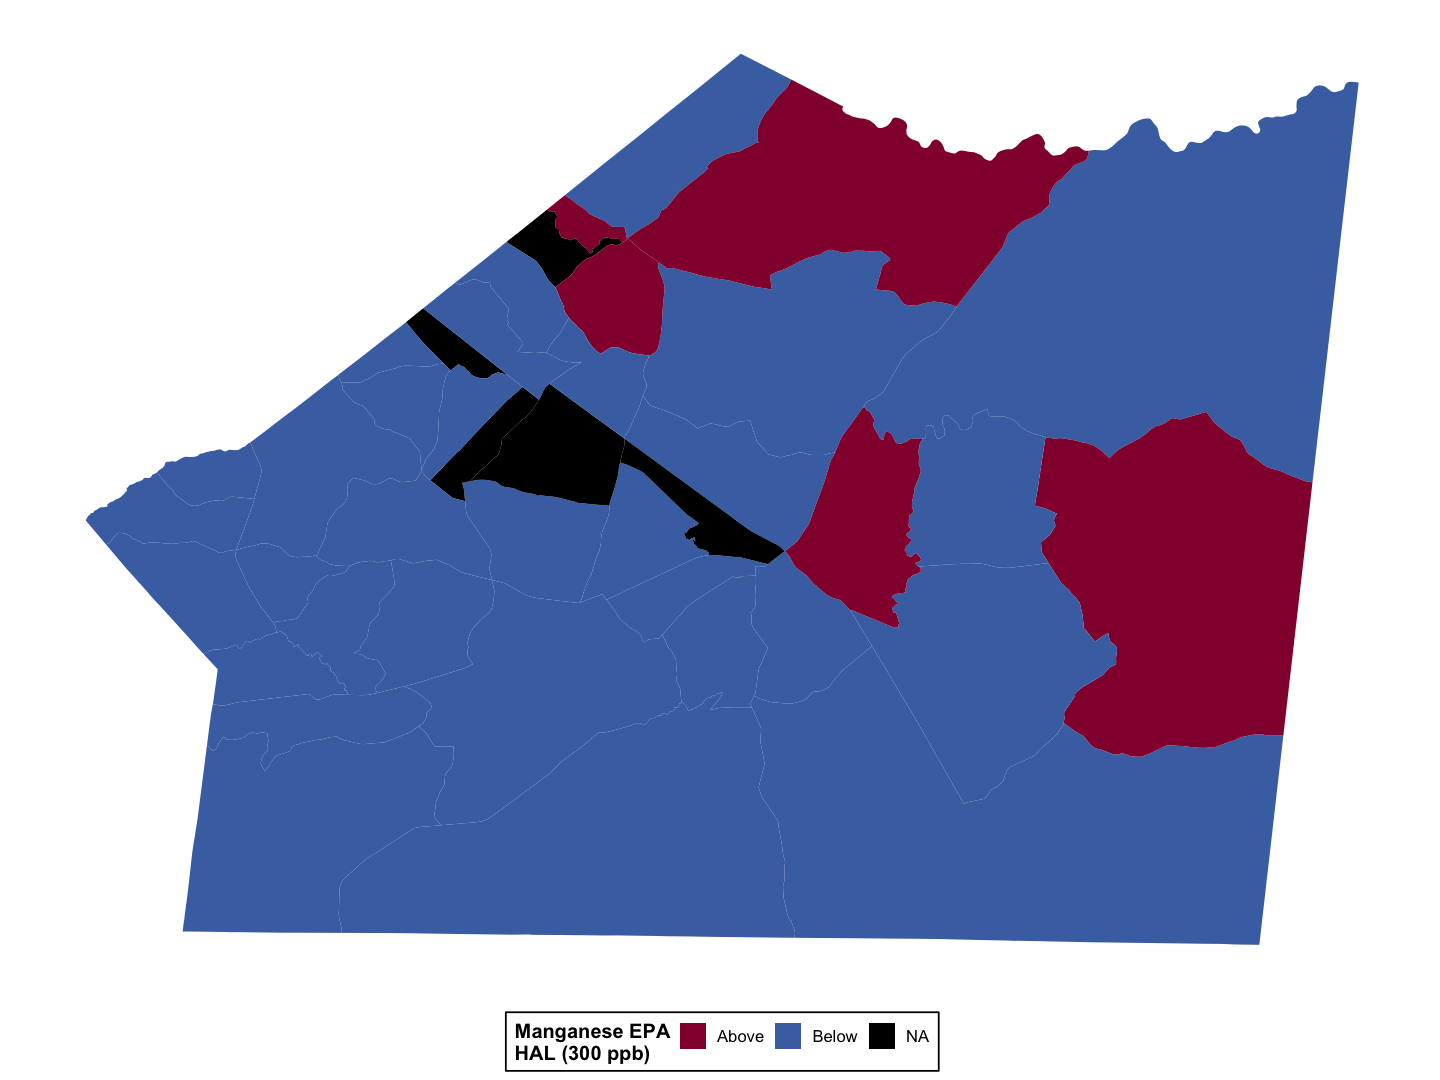

In [8]:
Figure1d = ggplot() +
  geom_sf(data = mn_df, aes(fill = HAL, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      #legend.position = c(0.5,0), # move legend to bottom middle
      legend.direction = "horizontal",
      legend.position = 'bottom',
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_manual(values = c("#93003a", "#4771b2"), 
                    na.value = "black", # making geo ids w/ NA values black
                    name = "Manganese EPA\nHAL (300 ppb)") 

Figure1d

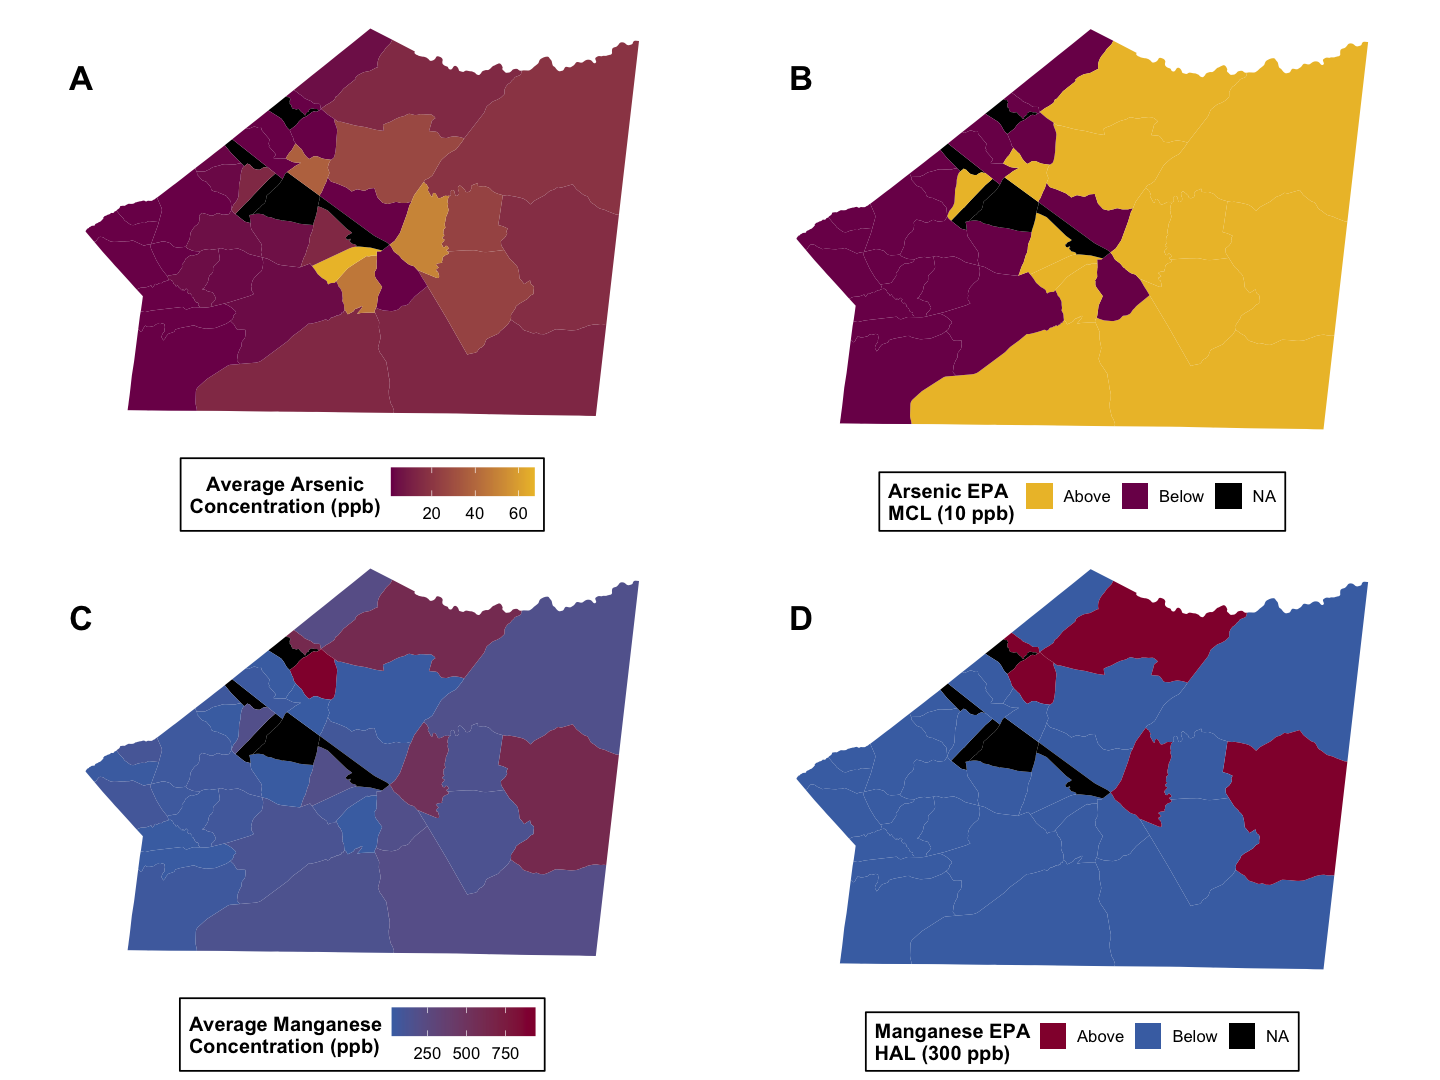

In [9]:
Figure1 = plot_grid(Figure1a, Figure1b, Figure1c, Figure1d,
                            # adding labels, changing size their size and position
                            labels = "AUTO", label_size = 20, label_x = 0.08, label_y = 0.9)
Figure1